# Chapter 5 - Indoor Scene Classification with TFLu and the Arduino Nano

In [172]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


### Python libraries

In [173]:
import numpy as np
import pathlib
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import tensorflow as tf
#import tensorflow_model_optimization as tfmot
#import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

### Constants

In [187]:
MODEL_ALPHA = 0.35
MODEL_INPUT_WIDTH = 60
MODEL_INPUT_HEIGHT = 60
TFL_MODEL_FILE = "temp5.tflite"
TFL_MODEL_HEADER_FILE = "temp6_model.h"
TF_MODEL = "model60x60v4"

## Transfer learning with Keras

### Unzip the dataset (dataset.zip) SKIP THIS STEP


In [175]:
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#   zip_ref.extractall(".")
# data_dir = "dataset"

### Prepare the train (80%) and validation (20%) datasets

In [176]:
data_dir="datasetv2v1hqequal"
train_ds = tf.keras.utils.image_dataset_from_directory(
  "edited_dataset_copy",
  validation_split=0,
  # subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

valid_ds=tf.keras.utils.image_dataset_from_directory(
  "valid_dataset",
  validation_split=0,
  # subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )
# rescale = tf.keras.layers.Rescaling(1./255, offset= -1)


Found 115 files belonging to 3 classes.
Found 30 files belonging to 3 classes.


### Get the name of the classes

In [177]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors']


### Rescale the pixel values from [0, 255] to [-1, 1]

In [178]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

valid_ds   = valid_ds.map(lambda x, y: (rescale(x), y))
# val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

### Import the MobileNet v2 pre-trained model

In [179]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)
base_model.trainable = False

feat_extr = base_model

### Augment the input data

In [180]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
# val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Prepare the classification head

In [181]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

### Build the model architecture

In [182]:
inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
x = global_avg_layer(feat_extr.layers[-1].output)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = dense_layer(x)
model = tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)

### Compile the model with a 0.0005 learning rate

In [183]:
lr = 0.0005
# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=200,
#     decay_rate=0.96,
#     staircase=True)
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Model summary

In [139]:
# model.summary()

### Train the model with 10 epochs

In [140]:
#model=tfmot.quantization.keras.quantizer_model(model)

In [184]:
history=model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=100
)

2023-07-10 22:24:22.201584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype resource
	 [[{{node Placeholder/_20}}]]
2023-07-10 22:24:22.205804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [115]
	 [[{{node Placeholder/_4}}]]


Epoch 1/100
3/4 [=====================>........] - ETA: 0s - loss: 1.7259 - accuracy: 0.3229

2023-07-10 22:24:28.453313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-10 22:24:28.453925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - 6s 532ms/step - loss: 1.6889 - accuracy: 0.2957 - val_loss: 1.3415 - val_accuracy: 0.4000
Epoch 2/100
4/4 [==============================] - 0s 93ms/step - loss: 1.6221 - accuracy: 0.2696 - val_loss: 1.2689 - val_accuracy: 0.4667
Epoch 3/100
4/4 [==============================] - 0s 93ms/step - loss: 1.4545 - accuracy: 0.3478 - val_loss: 1.2099 - val_accuracy: 0.4667
Epoch 4/100
4/4 [==============================] - 0s 99ms/step - loss: 1.4760 - accuracy: 0.3217 - val_loss: 1.1722 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 0s 84ms/step - loss: 1.3007 - accuracy: 0.4348 - val_loss: 1.1019 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 95ms/step - loss: 1.1953 - accuracy: 0.4522 - val_loss: 1.0375 - val_accuracy: 0.6000
Epoch 7/100
4/4 [==============================] - 0s 96ms/step - loss: 1.1907 - accuracy: 0.4522 - val_loss: 0.9774 - val_accuracy: 0.5333
Epoch 8/100
4/4 [==============

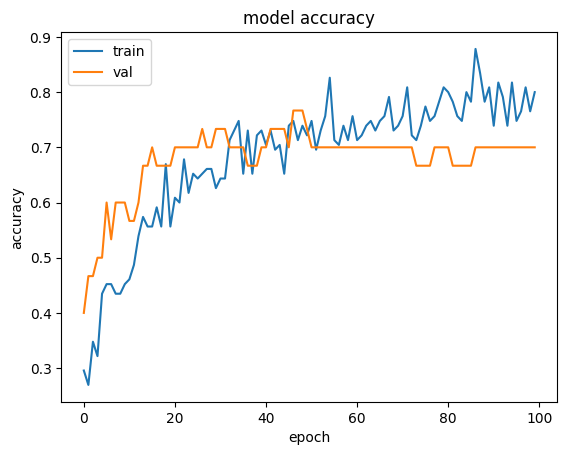

In [185]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

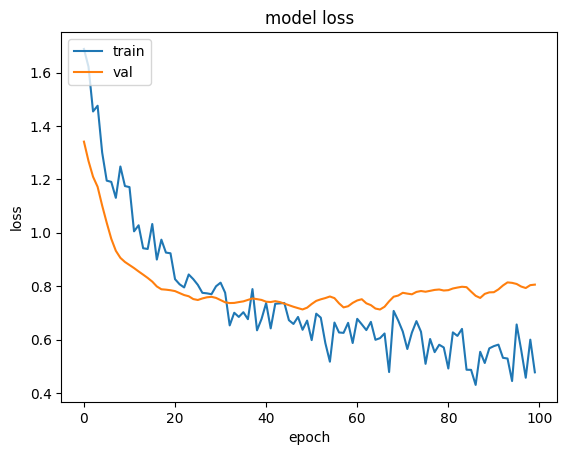

In [186]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save the TensorFlow model

In [188]:
model.save(TF_MODEL)

2023-07-10 22:27:25.527861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]
2023-07-10 22:27:35.311805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1280]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model60x60v4/assets


INFO:tensorflow:Assets written to: model60x60v4/assets


In [189]:
model=tf.keras.models.load_model("model60x60v4")

In [190]:
import os
import cv2
# real_labels=np.concatenate([y for x, y in val_ds], axis=0)
# Folder path containing the images
folder_path = "edited_dataset"  # Replace with the path to your folder
real_labels=[]
predicted_labels=[]


# Iterate over the images in the folder
for image, real_label in valid_ds:
    # if filename.endswith(".png"):  # Adjust the file extension if needed
        # Load and preprocess the image
        # image_path = os.path.join(folder_path, filename)
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        # image = cv2.resize(image, (MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
        # image = image / 255.0  # Normalize the image
        # image = np.expand_dims(image, axis=0)  # Add a batch dimension
        real_labels.append(real_label)
        # Make predictions
        predicted_label = np.argmax(model.predict(image), axis=1)
        # print(predicted_label)
        # predicted_label = class_names[np.argmax(predictions)]
        predicted_labels=(predicted_label)
        # Display the image and predicted label
        # plt.imshow(image[0])
        # plt.title(f"Predicted label: {predicted_label}")
        # plt.axis("off")
        # plt.show()
sum=0
for i in range(len(np.array(real_labels)[0])):
        if np.array(real_labels)[0][i]==predicted_labels[i]:
                sum+=1

print("Accuracy: ")
print(sum/len(predicted_labels))
# print(np.array(real_labels))
# print(predicted_labels)
tf.math.confusion_matrix(np.array(real_labels)[0], predicted_labels, 3)

1/1 [==============================] - 1s 1s/step
Accuracy: 
0.7


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[9, 0, 1],
       [1, 5, 4],
       [2, 1, 7]], dtype=int32)>

## Preparing and testing the quantized TFLite model

### Unzip the test dataset (test_samples.zip)

In [119]:
# with zipfile.ZipFile("test_samples.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# test_dir = "dataset"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [191]:
test_dir="edited_dataset_copy"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 115 files belonging to 3 classes.


### Quantize the TensorFlow model with the TFLite converter

In [192]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(100):
    yield [i_value]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tfl_model = converter.convert()

2023-07-10 22:29:36.302386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-10 22:29:36.302935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-10 22:29:36.305042: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model60x60v4
2023-07-10 22:29:36.358940: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-10 22:29:36.358968: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: model60x60v4
2023-07-10 22:29:36.741506: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-10 22:29:37.735654: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model60x60v4
2023-07-10 22:29:38.013003: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 1707971 microsecond

### Get the TFLite model size in bytes

In [122]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

619344 bytes


### Initialize the TFLite interpreter

In [193]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

### Get input quantization parameters

In [194]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
print(i_quant)
print(i_scale)
print(i_zero_point)

{'scales': array([0.00781238], dtype=float32), 'zero_points': array([-1], dtype=int32), 'quantized_dimension': 0}
0.00781238
-1


### Evaluate the accuracy of the quantized TFLite model

In [195]:
test_ds0 = valid_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))

real_labels=[]
predicted_labels=[]
for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]

  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

  real_labels.append(o_value)
  predicted_labels.append(np.argmax(o_pred))

print(tf.math.confusion_matrix(real_labels, predicted_labels, 3))
print("Accuracy:", num_correct_samples/num_total_samples)

2023-07-10 22:30:12.163634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-10 22:30:12.168770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-10 22:30:12.304170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{n

tf.Tensor(
[[9 0 1]
 [0 5 5]
 [2 1 7]], shape=(3, 3), dtype=int32)
Accuracy: 0.7


### Convert the TFLite model to C-byte array with xxd

In [196]:
open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i model.tflite > model60x60v4.cpp

zsh:1: command not found: apt-get
